<a href="https://colab.research.google.com/github/Nishant0851/HH/blob/master/PracticeProject(PUBG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBg Finish Placement Prediction

<img src='1.png'>

# Player Unknown Battleground

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys

sns.set_style('darkgrid')
sns.set_palette('bone')
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
def toTapleList(list1,list2):
    return list(itertools.product(list1,list2))

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load data

In [4]:
%%time
train = pd.read_csv('train_V2(Pubg).csv')
train = reduce_mem_usage(train)
test = pd.read_csv('test_V2(Pubg).csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 1.99 MB --> 0.68 MB (Decreased by 65.9%)
Memory usage of dataframe is 1.60 MB --> 0.54 MB (Decreased by 66.5%)
(8999, 29) (7505, 28)
CPU times: user 96.6 ms, sys: 13.8 ms, total: 110 ms
Wall time: 122 ms


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               8999 non-null   object 
 1   groupId          8999 non-null   object 
 2   matchId          8999 non-null   object 
 3   assists          8999 non-null   int8   
 4   boosts           8999 non-null   int8   
 5   damageDealt      8999 non-null   float32
 6   DBNOs            8999 non-null   int8   
 7   headshotKills    8999 non-null   int8   
 8   heals            8999 non-null   int8   
 9   killPlace        8999 non-null   int8   
 10  killPoints       8999 non-null   int16  
 11  kills            8999 non-null   int8   
 12  killStreaks      8999 non-null   int8   
 13  longestKill      8999 non-null   float32
 14  matchDuration    8999 non-null   int16  
 15  matchType        8999 non-null   object 
 16  maxPlace         8999 non-null   int8   
 17  numGroups     

In [6]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])
# dropna
train.dropna(inplace=True)

null count: Series([], dtype: int64)


In [7]:
train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.228,0.573,0.000,0.000,0.000,0.000,6.000
boosts,1.129,1.759,0.000,0.000,0.000,2.000,11.000
damageDealt,130.226,170.846,0.000,0.000,80.340,183.650,"2,325.000"
DBNOs,0.652,1.133,0.000,0.000,0.000,1.000,13.000
headshotKills,0.226,0.582,0.000,0.000,0.000,0.000,8.000
heals,1.375,2.666,0.000,0.000,0.000,2.000,29.000
killPlace,47.901,27.483,1.000,24.000,48.000,72.000,100.000
killPoints,507.422,627.486,0.000,0.000,0.000,"1,172.000","2,026.000"
kills,0.922,1.552,0.000,0.000,0.000,1.000,21.000
killStreaks,0.540,0.714,0.000,0.000,0.000,1.000,5.000


# Feature Engineering

In [8]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

<ipython-input-8-850c63133ccd>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = train.append(test, sort=False).reset_index(drop=True)


0

## new feature

In [9]:
def fillInf(df, val):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: df[c].fillna(val, inplace=True)

In [10]:
all_data['_totalDistance'] = all_data['rideDistance'] + all_data['walkDistance'] + all_data['swimDistance']
all_data['_healthItems'] = all_data['heals'] + all_data['boosts']
all_data['_headshotKillRate'] = all_data['headshotKills'] / all_data['kills']
all_data['_killPlaceOverMaxPlace'] = all_data['killPlace'] / all_data['maxPlace']
all_data['_killsOverWalkDistance'] = all_data['kills'] / all_data['walkDistance']
#all_data['_killsOverDistance'] = all_data['kills'] / all_data['_totalDistance']
#all_data['_walkDistancePerSec'] = all_data['walkDistance'] / all_data['matchDuration']

fillInf(all_data, 0)

## rank as percent

In [11]:
match = all_data.groupby('matchId')
all_data['killsPerc'] = match['kills'].rank(pct=True).values
all_data['killPlacePerc'] = match['killPlace'].rank(pct=True).values
all_data['walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
#all_data['damageDealtPerc'] = match['damageDealt'].rank(pct=True).values

all_data['walkPerc_killsPerc'] = all_data['walkDistancePerc'] / all_data['killsPerc']
#all_data['walkPerc_kills'] = all_data['walkDistancePerc'] / all_data['kills']
#all_data['kills_walkPerc'] = all_data['kills'] / all_data['walkDistancePerc']

## drop feature

In [12]:
#all_data.drop(['killStreaks','DBNOs'], axis=1, inplace=True)
all_data.drop(['boosts','heals','revives','assists'], axis=1, inplace=True)
all_data.drop(['headshotKills','roadKills','vehicleDestroys','teamKills'], axis=1, inplace=True)
all_data.drop(['rideDistance','swimDistance','matchDuration'], axis=1, inplace=True)
all_data.drop(['rankPoints','killPoints','winPoints'], axis=1, inplace=True)

## grouping

* need to predict the order of places for groups within each match.
* train on group-level instead of the user-level

In [13]:
match = all_data.groupby(['matchId'])
group = all_data.groupby(['matchId','groupId','matchType'])

# target feature (max, min)
agg_col = list(all_data.columns)
exclude_agg_col = ['Id','matchId','groupId','matchType','maxPlace','numGroups','winPlacePerc']
for c in exclude_agg_col:
    agg_col.remove(c)
print(agg_col)

# target feature (sum)
sum_col = ['kills','killPlace','damageDealt','walkDistance','_healthItems']

['damageDealt', 'DBNOs', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'walkDistance', 'weaponsAcquired', ' Id', '_totalDistance', '_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', 'killsPerc', 'killPlacePerc', 'walkDistancePerc', 'walkPerc_killsPerc']


In [14]:
''' match sum, match max, match mean, group sum
'''
match_data = pd.concat([
    match.size().to_frame('m.players'),
    match[sum_col].sum().rename(columns=lambda s: 'm.sum.' + s),
    match[sum_col].max().rename(columns=lambda s: 'm.max.' + s),
    match[sum_col].mean().rename(columns=lambda s: 'm.mean.' + s)
    ], axis=1).reset_index()
match_data = pd.merge(match_data,
    group[sum_col].sum().rename(columns=lambda s: 'sum.' + s).reset_index())
match_data = reduce_mem_usage(match_data)

print(match_data.shape)

Memory usage of dataframe is 2.31 MB --> 1.38 MB (Decreased by 40.1%)
(16461, 24)


In [15]:
''' ranking of kills and killPlace in each match
'''
minKills = all_data.sort_values(['matchId','groupId','kills','killPlace']).groupby(
    ['matchId','groupId','kills']).first().reset_index().copy()
for n in np.arange(5):
    c = 'kills_' + str(n) + '_Place'
    nKills = (minKills['kills'] == n)
    minKills.loc[nKills, c] = minKills[nKills].groupby(['matchId'])['killPlace'].rank().values
    match_data = pd.merge(match_data, minKills[nKills][['matchId','groupId',c]], how='left')
    match_data[c].fillna(0, inplace=True)
match_data = reduce_mem_usage(match_data)
del minKills, nKills

print(match_data.shape)

Memory usage of dataframe is 2.01 MB --> 1.70 MB (Decreased by 15.6%)
(16461, 29)


In [16]:
''' group mean, max, min
'''
all_data = pd.concat([
    group.size().to_frame('players'),
    group.mean(),
    group[agg_col].max().rename(columns=lambda s: 'max.' + s),
    group[agg_col].min().rename(columns=lambda s: 'min.' + s),
    ], axis=1).reset_index()
all_data = reduce_mem_usage(all_data)

print(all_data.shape)

<ipython-input-16-817fe0afeda2>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group.mean(),


Memory usage of dataframe is 5.21 MB --> 3.47 MB (Decreased by 33.4%)
(16461, 60)


## aggregate feature

In [17]:
numcols = all_data.select_dtypes(include='number').columns.values
numcols = numcols[numcols != 'winPlacePerc']

In [18]:
''' match summary, max
'''
all_data = pd.merge(all_data, match_data)
del match_data
gc.collect()

all_data['enemy.players'] = all_data['m.players'] - all_data['players']
for c in sum_col:
    all_data['enemy.' + c] = (all_data['m.sum.' + c] - all_data['sum.' + c]) / all_data['enemy.players']
    #all_data['p.sum_msum.' + c] = all_data['sum.' + c] / all_data['m.sum.' + c]
    #all_data['p.max_mmean.' + c] = all_data['max.' + c] / all_data['m.mean.' + c]
    all_data['p.max_msum.' + c] = all_data['max.' + c] / all_data['m.sum.' + c]
    all_data['p.max_mmax.' + c] = all_data['max.' + c] / all_data['m.max.' + c]
    all_data.drop(['m.sum.' + c, 'm.max.' + c], axis=1, inplace=True)

fillInf(all_data, 0)
print(all_data.shape)

(16461, 92)


In [19]:
''' match rank
'''
match = all_data.groupby('matchId')
matchRank = match[numcols].rank(pct=True).rename(columns=lambda s: 'rank.' + s)
all_data = reduce_mem_usage(pd.concat([all_data, matchRank], axis=1))
rank_col = matchRank.columns
del matchRank
gc.collect()

# instead of rank(pct=True, method='dense')
match = all_data.groupby('matchId')
matchRank = match[rank_col].max().rename(columns=lambda s: 'max.' + s).reset_index()
all_data = pd.merge(all_data, matchRank)
for c in numcols:
    all_data['rank.' + c] = all_data['rank.' + c] / all_data['max.rank.' + c]
    all_data.drop(['max.rank.' + c], axis=1, inplace=True)
del matchRank
gc.collect()

print(all_data.shape)

Memory usage of dataframe is 12.73 MB --> 8.78 MB (Decreased by 31.1%)
(16461, 146)


## killPlace rank of group and kills

In [20]:
''' TODO: incomplete
'''
killMinorRank = all_data[['matchId','min.kills','max.killPlace']].copy()
group = killMinorRank.groupby(['matchId','min.kills'])
killMinorRank['rank.minor.maxKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

killMinorRank = all_data[['matchId','max.kills','min.killPlace']].copy()
group = killMinorRank.groupby(['matchId','max.kills'])
killMinorRank['rank.minor.minKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

del killMinorRank
gc.collect()

0

## drop constant feature

In [21]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: ['rank.maxPlace', 'rank.numGroups']


## encode

In [22]:
'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
all_data['matchType'] = all_data['matchType'].apply(mapper)

all_data = pd.concat([all_data, pd.get_dummies(all_data['matchType'], prefix='matchType')], axis=1)

In [23]:
cols = [col for col in all_data.columns if col not in ['Id','matchId','groupId']]
for i, t in all_data.loc[:, cols].dtypes.iteritems():
    if t == object:
        all_data[i] = pd.factorize(all_data[i])[0]

all_data = reduce_mem_usage(all_data)
all_data.head()

Memory usage of dataframe is 8.95 MB --> 8.67 MB (Decreased by 3.2%)


<ipython-input-23-0c7c09843779>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, t in all_data.loc[:, cols].dtypes.iteritems():


,matchId,groupId,matchType,players,damageDealt,DBNOs,killPlace,kills,killStreaks,longestKill,...,rank.min._killsOverWalkDistance,rank.min.killsPerc,rank.min.killPlacePerc,rank.min.walkDistancePerc,rank.min.walkPerc_killsPerc,rank.minor.maxKillPlace,rank.minor.minKillPlace,matchType_duo,matchType_solo,matchType_squad
0,0000a43bce5eec,7bd08592bb25e2,0,1,0.000,0.000,41.000,0.000,0.000,0.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000
1,0000eb01ea6cdd,338a69335655a6,0,1,210.900,1.000,29.000,1.000,1.000,92.570,...,0.500,0.500,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000
2,0000eb01ea6cdd,e89636a86735d3,0,1,300.000,2.000,11.000,3.000,3.000,19.330,...,1.000,1.000,0.500,0.500,0.500,1.000,1.000,0.000,0.000,1.000
3,00086e740a5804,4018d80e8ad32a,1,1,177.400,0.000,62.000,0.000,0.000,0.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000
4,0008c31a9be4a7,26d4045668cf95,0,1,0.000,0.000,74.000,0.000,0.000,0.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000


# Predict

In [24]:
X_train = all_data[all_data['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = all_data[all_data['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)
del all_data
gc.collect()

Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()

# drop matchId,groupId
X_train.drop(['matchId','groupId'], axis=1, inplace=True)
X_test.drop(['matchId','groupId'], axis=1, inplace=True)

X_train_cols = X_train.columns

print(X_train.shape, X_test.shape)

(8972, 146) (7489, 146)


In [26]:
print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

           name     size
0       X_train  4701472
1        X_test  3924380
2    X_test_grp  1063582
3       Y_train    36032
4  X_train_cols    15039
5      rank_col     6294
6            _7     3642
7             _     3406
8           _23     3406
9      null_cnt     2171


In [27]:
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, BatchNormalization, PReLU
from keras.models import load_model
from keras.models import Sequential

def createModel():
    model = Sequential()
    model.add(Dense(512, kernel_initializer='he_normal', input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(256, kernel_initializer='he_normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    optimizer = optimizers.Adam(lr=0.005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])

    return model

import tensorflow as tf
print(tf.__version__)

In [28]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10, verbose=0):
    ''' Wrapper function to create a LearningRateScheduler with step decay schedule. '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))

    return LearningRateScheduler(schedule, verbose)

lr_sched = step_decay_schedule(initial_lr=0.001, decay_factor=0.97, step_size=1, verbose=1)
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=10, verbose=1)

In [33]:
from sklearn import preprocessing
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(1234)

scaler = preprocessing.StandardScaler().fit((X_train).astype(float))
X_train = scaler.transform((X_train).astype(float))
X_test = scaler.transform((X_test).astype(float))

model = createModel()
history = model.fit(
        X_train, Y_train,
        epochs=200,
        batch_size=2**15,
        validation_split=0.2,
        callbacks=[lr_sched, early_stopping],
        verbose=2)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200


1/1 - 3s - loss: 0.0911 - mae: 0.2538 - val_loss: 0.0598 - val_mae: 0.2086 - lr: 0.0010 - 3s/epoch - 3s/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0009699999999999999.
Epoch 2/200


1/1 - 0s - loss: 0.0396 - mae: 0.1597 - val_loss: 0.0387 - val_mae: 0.1628 - lr: 9.7000e-04 - 395ms/epoch - 395ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0009408999999999999.
Epoch 3/200


1/1 - 0s - loss: 0.0292 - mae: 0.1308 - val_loss: 0.0312 - val_mae: 0.1410 - lr: 9.4090e-04 - 454ms/epoch - 454ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.000912673.
Epoch 4/200


1/1 - 0s - loss: 0.0260 - mae: 0.1213 - val_loss: 0.0280 - val_mae: 0.1300 - lr: 9.1267e-04 - 387ms/epoch - 387ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.00088529281.
Epoch 5/200


1/1 - 0s - loss: 0.0246 - mae: 0.1163 - val_loss: 0.0261 - val_mae: 0.1234 - lr: 8.8529e-04 - 386ms/epoch - 386ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0008587340257.
Epoch 6/200


1/1 - 0s - loss: 0.0236 - mae: 0.1133 - val_loss: 0.0248 - val_mae: 0.1186 - lr: 8.5873e-04 - 455ms/epoch - 455ms/step

Epoch 7: LearningRateScheduler setting learning rate to 0.0008329720049289998.
Epoch 7/200


1/1 - 0s - loss: 0.0226 - mae: 0.1104 - val_loss: 0.0238 - val_mae: 0.1150 - lr: 8.3297e-04 - 436ms/epoch - 436ms/step

Epoch 8: LearningRateScheduler setting learning rate to 0.0008079828447811299.
Epoch 8/200


1/1 - 0s - loss: 0.0211 - mae: 0.1074 - val_loss: 0.0230 - val_mae: 0.1124 - lr: 8.0798e-04 - 400ms/epoch - 400ms/step

Epoch 9: LearningRateScheduler setting learning rate to 0.0007837433594376959.
Epoch 9/200


1/1 - 0s - loss: 0.0203 - mae: 0.1056 - val_loss: 0.0224 - val_mae: 0.1105 - lr: 7.8374e-04 - 433ms/epoch - 433ms/step

Epoch 10: LearningRateScheduler setting learning rate to 0.0007602310586545651.
Epoch 10/200


1/1 - 0s - loss: 0.0201 - mae: 0.1047 - val_loss: 0.0220 - val_mae: 0.1090 - lr: 7.6023e-04 - 425ms/epoch - 425ms/step

Epoch 11: LearningRateScheduler setting learning rate to 0.0007374241268949281.
Epoch 11/200


1/1 - 0s - loss: 0.0190 - mae: 0.1023 - val_loss: 0.0217 - val_mae: 0.1079 - lr: 7.3742e-04 - 496ms/epoch - 496ms/step

Epoch 12: LearningRateScheduler setting learning rate to 0.0007153014030880803.
Epoch 12/200


1/1 - 1s - loss: 0.0177 - mae: 0.0989 - val_loss: 0.0215 - val_mae: 0.1073 - lr: 7.1530e-04 - 660ms/epoch - 660ms/step

Epoch 13: LearningRateScheduler setting learning rate to 0.0006938423609954377.
Epoch 13/200


1/1 - 1s - loss: 0.0171 - mae: 0.0972 - val_loss: 0.0215 - val_mae: 0.1071 - lr: 6.9384e-04 - 600ms/epoch - 600ms/step

Epoch 14: LearningRateScheduler setting learning rate to 0.0006730270901655746.
Epoch 14/200


1/1 - 1s - loss: 0.0170 - mae: 0.0969 - val_loss: 0.0215 - val_mae: 0.1069 - lr: 6.7303e-04 - 667ms/epoch - 667ms/step

Epoch 15: LearningRateScheduler setting learning rate to 0.0006528362774606074.
Epoch 15/200


1/1 - 1s - loss: 0.0166 - mae: 0.0956 - val_loss: 0.0214 - val_mae: 0.1067 - lr: 6.5284e-04 - 691ms/epoch - 691ms/step

Epoch 16: LearningRateScheduler setting learning rate to 0.0006332511891367892.
Epoch 16/200


1/1 - 0s - loss: 0.0164 - mae: 0.0956 - val_loss: 0.0213 - val_mae: 0.1063 - lr: 6.3325e-04 - 418ms/epoch - 418ms/step

Epoch 17: LearningRateScheduler setting learning rate to 0.0006142536534626855.
Epoch 17/200


1/1 - 0s - loss: 0.0161 - mae: 0.0953 - val_loss: 0.0210 - val_mae: 0.1056 - lr: 6.1425e-04 - 388ms/epoch - 388ms/step

Epoch 18: LearningRateScheduler setting learning rate to 0.0005958260438588049.
Epoch 18/200


1/1 - 0s - loss: 0.0161 - mae: 0.0947 - val_loss: 0.0207 - val_mae: 0.1046 - lr: 5.9583e-04 - 440ms/epoch - 440ms/step

Epoch 19: LearningRateScheduler setting learning rate to 0.0005779512625430407.
Epoch 19/200


1/1 - 0s - loss: 0.0160 - mae: 0.0951 - val_loss: 0.0203 - val_mae: 0.1035 - lr: 5.7795e-04 - 395ms/epoch - 395ms/step

Epoch 20: LearningRateScheduler setting learning rate to 0.0005606127246667495.
Epoch 20/200


1/1 - 0s - loss: 0.0159 - mae: 0.0940 - val_loss: 0.0199 - val_mae: 0.1024 - lr: 5.6061e-04 - 449ms/epoch - 449ms/step

Epoch 21: LearningRateScheduler setting learning rate to 0.000543794342926747.
Epoch 21/200


1/1 - 0s - loss: 0.0155 - mae: 0.0933 - val_loss: 0.0195 - val_mae: 0.1013 - lr: 5.4379e-04 - 397ms/epoch - 397ms/step

Epoch 22: LearningRateScheduler setting learning rate to 0.0005274805126389446.
Epoch 22/200


1/1 - 0s - loss: 0.0153 - mae: 0.0922 - val_loss: 0.0191 - val_mae: 0.1004 - lr: 5.2748e-04 - 388ms/epoch - 388ms/step

Epoch 23: LearningRateScheduler setting learning rate to 0.0005116560972597763.
Epoch 23/200


1/1 - 0s - loss: 0.0148 - mae: 0.0914 - val_loss: 0.0189 - val_mae: 0.0996 - lr: 5.1166e-04 - 428ms/epoch - 428ms/step

Epoch 24: LearningRateScheduler setting learning rate to 0.0004963064143419829.
Epoch 24/200


1/1 - 0s - loss: 0.0148 - mae: 0.0913 - val_loss: 0.0186 - val_mae: 0.0989 - lr: 4.9631e-04 - 405ms/epoch - 405ms/step

Epoch 25: LearningRateScheduler setting learning rate to 0.00048141722191172336.
Epoch 25/200


1/1 - 0s - loss: 0.0147 - mae: 0.0907 - val_loss: 0.0184 - val_mae: 0.0983 - lr: 4.8142e-04 - 393ms/epoch - 393ms/step

Epoch 26: LearningRateScheduler setting learning rate to 0.0004669747052543717.
Epoch 26/200


1/1 - 0s - loss: 0.0145 - mae: 0.0900 - val_loss: 0.0183 - val_mae: 0.0979 - lr: 4.6697e-04 - 429ms/epoch - 429ms/step

Epoch 27: LearningRateScheduler setting learning rate to 0.0004529654640967405.
Epoch 27/200


1/1 - 0s - loss: 0.0144 - mae: 0.0894 - val_loss: 0.0182 - val_mae: 0.0977 - lr: 4.5297e-04 - 447ms/epoch - 447ms/step

Epoch 28: LearningRateScheduler setting learning rate to 0.0004393765001738383.
Epoch 28/200


1/1 - 0s - loss: 0.0144 - mae: 0.0891 - val_loss: 0.0181 - val_mae: 0.0975 - lr: 4.3938e-04 - 422ms/epoch - 422ms/step

Epoch 29: LearningRateScheduler setting learning rate to 0.0004261952051686231.
Epoch 29/200


1/1 - 0s - loss: 0.0144 - mae: 0.0893 - val_loss: 0.0181 - val_mae: 0.0975 - lr: 4.2620e-04 - 395ms/epoch - 395ms/step

Epoch 30: LearningRateScheduler setting learning rate to 0.0004134093490135644.
Epoch 30/200


1/1 - 0s - loss: 0.0140 - mae: 0.0878 - val_loss: 0.0181 - val_mae: 0.0975 - lr: 4.1341e-04 - 418ms/epoch - 418ms/step

Epoch 31: LearningRateScheduler setting learning rate to 0.00040100706854315747.
Epoch 31/200


1/1 - 0s - loss: 0.0139 - mae: 0.0877 - val_loss: 0.0181 - val_mae: 0.0975 - lr: 4.0101e-04 - 441ms/epoch - 441ms/step

Epoch 32: LearningRateScheduler setting learning rate to 0.00038897685648686274.
Epoch 32/200


1/1 - 0s - loss: 0.0139 - mae: 0.0877 - val_loss: 0.0181 - val_mae: 0.0975 - lr: 3.8898e-04 - 404ms/epoch - 404ms/step

Epoch 33: LearningRateScheduler setting learning rate to 0.00037730755079225687.
Epoch 33/200


1/1 - 0s - loss: 0.0139 - mae: 0.0876 - val_loss: 0.0181 - val_mae: 0.0975 - lr: 3.7731e-04 - 447ms/epoch - 447ms/step

Epoch 34: LearningRateScheduler setting learning rate to 0.00036598832426848916.
Epoch 34/200


1/1 - 0s - loss: 0.0137 - mae: 0.0871 - val_loss: 0.0181 - val_mae: 0.0975 - lr: 3.6599e-04 - 421ms/epoch - 421ms/step

Epoch 35: LearningRateScheduler setting learning rate to 0.00035500867454043444.
Epoch 35/200


1/1 - 0s - loss: 0.0139 - mae: 0.0875 - val_loss: 0.0180 - val_mae: 0.0975 - lr: 3.5501e-04 - 437ms/epoch - 437ms/step

Epoch 36: LearningRateScheduler setting learning rate to 0.0003443584143042214.
Epoch 36/200


1/1 - 0s - loss: 0.0136 - mae: 0.0864 - val_loss: 0.0180 - val_mae: 0.0973 - lr: 3.4436e-04 - 427ms/epoch - 427ms/step

Epoch 37: LearningRateScheduler setting learning rate to 0.00033402766187509475.
Epoch 37/200


1/1 - 0s - loss: 0.0136 - mae: 0.0866 - val_loss: 0.0179 - val_mae: 0.0972 - lr: 3.3403e-04 - 395ms/epoch - 395ms/step

Epoch 38: LearningRateScheduler setting learning rate to 0.0003240068320188419.
Epoch 38/200


1/1 - 0s - loss: 0.0136 - mae: 0.0866 - val_loss: 0.0178 - val_mae: 0.0969 - lr: 3.2401e-04 - 424ms/epoch - 424ms/step

Epoch 39: LearningRateScheduler setting learning rate to 0.00031428662705827666.
Epoch 39/200


1/1 - 1s - loss: 0.0135 - mae: 0.0861 - val_loss: 0.0177 - val_mae: 0.0966 - lr: 3.1429e-04 - 550ms/epoch - 550ms/step

Epoch 40: LearningRateScheduler setting learning rate to 0.0003048580282465283.
Epoch 40/200


1/1 - 1s - loss: 0.0131 - mae: 0.0859 - val_loss: 0.0176 - val_mae: 0.0963 - lr: 3.0486e-04 - 663ms/epoch - 663ms/step

Epoch 41: LearningRateScheduler setting learning rate to 0.0002957122873991325.
Epoch 41/200


1/1 - 1s - loss: 0.0135 - mae: 0.0864 - val_loss: 0.0175 - val_mae: 0.0960 - lr: 2.9571e-04 - 667ms/epoch - 667ms/step

Epoch 42: LearningRateScheduler setting learning rate to 0.00028684091877715853.
Epoch 42/200


1/1 - 1s - loss: 0.0132 - mae: 0.0856 - val_loss: 0.0173 - val_mae: 0.0956 - lr: 2.8684e-04 - 656ms/epoch - 656ms/step

Epoch 43: LearningRateScheduler setting learning rate to 0.00027823569121384375.
Epoch 43/200


1/1 - 1s - loss: 0.0133 - mae: 0.0859 - val_loss: 0.0172 - val_mae: 0.0953 - lr: 2.7824e-04 - 582ms/epoch - 582ms/step

Epoch 44: LearningRateScheduler setting learning rate to 0.0002698886204774284.
Epoch 44/200


1/1 - 0s - loss: 0.0133 - mae: 0.0859 - val_loss: 0.0171 - val_mae: 0.0949 - lr: 2.6989e-04 - 439ms/epoch - 439ms/step

Epoch 45: LearningRateScheduler setting learning rate to 0.00026179196186310554.
Epoch 45/200


1/1 - 0s - loss: 0.0133 - mae: 0.0860 - val_loss: 0.0169 - val_mae: 0.0945 - lr: 2.6179e-04 - 451ms/epoch - 451ms/step

Epoch 46: LearningRateScheduler setting learning rate to 0.0002539382030072124.
Epoch 46/200


1/1 - 0s - loss: 0.0134 - mae: 0.0865 - val_loss: 0.0168 - val_mae: 0.0942 - lr: 2.5394e-04 - 396ms/epoch - 396ms/step

Epoch 47: LearningRateScheduler setting learning rate to 0.000246320056916996.
Epoch 47/200


1/1 - 0s - loss: 0.0132 - mae: 0.0858 - val_loss: 0.0167 - val_mae: 0.0938 - lr: 2.4632e-04 - 456ms/epoch - 456ms/step

Epoch 48: LearningRateScheduler setting learning rate to 0.00023893045520948612.
Epoch 48/200


1/1 - 0s - loss: 0.0134 - mae: 0.0864 - val_loss: 0.0165 - val_mae: 0.0934 - lr: 2.3893e-04 - 448ms/epoch - 448ms/step

Epoch 49: LearningRateScheduler setting learning rate to 0.00023176254155320153.
Epoch 49/200


1/1 - 0s - loss: 0.0132 - mae: 0.0860 - val_loss: 0.0164 - val_mae: 0.0931 - lr: 2.3176e-04 - 422ms/epoch - 422ms/step

Epoch 50: LearningRateScheduler setting learning rate to 0.00022480966530660546.
Epoch 50/200


1/1 - 0s - loss: 0.0134 - mae: 0.0863 - val_loss: 0.0163 - val_mae: 0.0928 - lr: 2.2481e-04 - 416ms/epoch - 416ms/step

Epoch 51: LearningRateScheduler setting learning rate to 0.0002180653753474073.
Epoch 51/200


1/1 - 0s - loss: 0.0131 - mae: 0.0857 - val_loss: 0.0162 - val_mae: 0.0925 - lr: 2.1807e-04 - 389ms/epoch - 389ms/step

Epoch 52: LearningRateScheduler setting learning rate to 0.00021152341408698508.
Epoch 52/200


1/1 - 0s - loss: 0.0130 - mae: 0.0853 - val_loss: 0.0162 - val_mae: 0.0923 - lr: 2.1152e-04 - 426ms/epoch - 426ms/step

Epoch 53: LearningRateScheduler setting learning rate to 0.0002051777116643755.
Epoch 53/200


1/1 - 0s - loss: 0.0130 - mae: 0.0852 - val_loss: 0.0161 - val_mae: 0.0921 - lr: 2.0518e-04 - 405ms/epoch - 405ms/step

Epoch 54: LearningRateScheduler setting learning rate to 0.00019902238031444425.
Epoch 54/200


1/1 - 0s - loss: 0.0131 - mae: 0.0851 - val_loss: 0.0160 - val_mae: 0.0919 - lr: 1.9902e-04 - 413ms/epoch - 413ms/step

Epoch 55: LearningRateScheduler setting learning rate to 0.0001930517089050109.
Epoch 55/200


1/1 - 0s - loss: 0.0132 - mae: 0.0862 - val_loss: 0.0160 - val_mae: 0.0917 - lr: 1.9305e-04 - 454ms/epoch - 454ms/step

Epoch 56: LearningRateScheduler setting learning rate to 0.00018726015763786058.
Epoch 56/200


1/1 - 0s - loss: 0.0129 - mae: 0.0849 - val_loss: 0.0159 - val_mae: 0.0915 - lr: 1.8726e-04 - 406ms/epoch - 406ms/step

Epoch 57: LearningRateScheduler setting learning rate to 0.00018164235290872477.
Epoch 57/200


1/1 - 0s - loss: 0.0129 - mae: 0.0847 - val_loss: 0.0158 - val_mae: 0.0913 - lr: 1.8164e-04 - 463ms/epoch - 463ms/step

Epoch 58: LearningRateScheduler setting learning rate to 0.000176193082321463.
Epoch 58/200


1/1 - 0s - loss: 0.0128 - mae: 0.0849 - val_loss: 0.0158 - val_mae: 0.0912 - lr: 1.7619e-04 - 388ms/epoch - 388ms/step

Epoch 59: LearningRateScheduler setting learning rate to 0.0001709072898518191.
Epoch 59/200


1/1 - 0s - loss: 0.0127 - mae: 0.0843 - val_loss: 0.0157 - val_mae: 0.0910 - lr: 1.7091e-04 - 440ms/epoch - 440ms/step

Epoch 60: LearningRateScheduler setting learning rate to 0.00016578007115626453.
Epoch 60/200


1/1 - 0s - loss: 0.0125 - mae: 0.0835 - val_loss: 0.0157 - val_mae: 0.0909 - lr: 1.6578e-04 - 435ms/epoch - 435ms/step

Epoch 61: LearningRateScheduler setting learning rate to 0.0001608066690215766.
Epoch 61/200


1/1 - 0s - loss: 0.0129 - mae: 0.0848 - val_loss: 0.0156 - val_mae: 0.0907 - lr: 1.6081e-04 - 435ms/epoch - 435ms/step

Epoch 62: LearningRateScheduler setting learning rate to 0.0001559824689509293.
Epoch 62/200


1/1 - 0s - loss: 0.0129 - mae: 0.0849 - val_loss: 0.0156 - val_mae: 0.0905 - lr: 1.5598e-04 - 400ms/epoch - 400ms/step

Epoch 63: LearningRateScheduler setting learning rate to 0.0001513029948824014.
Epoch 63/200


1/1 - 0s - loss: 0.0128 - mae: 0.0843 - val_loss: 0.0155 - val_mae: 0.0904 - lr: 1.5130e-04 - 434ms/epoch - 434ms/step

Epoch 64: LearningRateScheduler setting learning rate to 0.00014676390503592937.
Epoch 64/200


1/1 - 0s - loss: 0.0128 - mae: 0.0840 - val_loss: 0.0155 - val_mae: 0.0902 - lr: 1.4676e-04 - 411ms/epoch - 411ms/step

Epoch 65: LearningRateScheduler setting learning rate to 0.0001423609878848515.
Epoch 65/200


1/1 - 0s - loss: 0.0125 - mae: 0.0835 - val_loss: 0.0154 - val_mae: 0.0900 - lr: 1.4236e-04 - 391ms/epoch - 391ms/step

Epoch 66: LearningRateScheduler setting learning rate to 0.00013809015824830593.
Epoch 66/200


1/1 - 0s - loss: 0.0127 - mae: 0.0841 - val_loss: 0.0153 - val_mae: 0.0898 - lr: 1.3809e-04 - 467ms/epoch - 467ms/step

Epoch 67: LearningRateScheduler setting learning rate to 0.00013394745350085675.
Epoch 67/200


1/1 - 1s - loss: 0.0125 - mae: 0.0833 - val_loss: 0.0153 - val_mae: 0.0897 - lr: 1.3395e-04 - 654ms/epoch - 654ms/step

Epoch 68: LearningRateScheduler setting learning rate to 0.00012992902989583105.
Epoch 68/200


1/1 - 1s - loss: 0.0129 - mae: 0.0847 - val_loss: 0.0153 - val_mae: 0.0895 - lr: 1.2993e-04 - 663ms/epoch - 663ms/step

Epoch 69: LearningRateScheduler setting learning rate to 0.00012603115899895612.
Epoch 69/200


1/1 - 1s - loss: 0.0126 - mae: 0.0839 - val_loss: 0.0152 - val_mae: 0.0894 - lr: 1.2603e-04 - 636ms/epoch - 636ms/step

Epoch 70: LearningRateScheduler setting learning rate to 0.00012225022422898742.
Epoch 70/200


1/1 - 1s - loss: 0.0128 - mae: 0.0842 - val_loss: 0.0152 - val_mae: 0.0893 - lr: 1.2225e-04 - 657ms/epoch - 657ms/step

Epoch 71: LearningRateScheduler setting learning rate to 0.0001185827175021178.
Epoch 71/200


1/1 - 0s - loss: 0.0126 - mae: 0.0835 - val_loss: 0.0151 - val_mae: 0.0891 - lr: 1.1858e-04 - 390ms/epoch - 390ms/step

Epoch 72: LearningRateScheduler setting learning rate to 0.00011502523597705427.
Epoch 72/200


1/1 - 0s - loss: 0.0126 - mae: 0.0840 - val_loss: 0.0150 - val_mae: 0.0889 - lr: 1.1503e-04 - 449ms/epoch - 449ms/step

Epoch 73: LearningRateScheduler setting learning rate to 0.00011157447889774264.
Epoch 73/200


1/1 - 0s - loss: 0.0128 - mae: 0.0840 - val_loss: 0.0150 - val_mae: 0.0888 - lr: 1.1157e-04 - 441ms/epoch - 441ms/step

Epoch 74: LearningRateScheduler setting learning rate to 0.00010822724453081035.
Epoch 74/200


1/1 - 0s - loss: 0.0128 - mae: 0.0841 - val_loss: 0.0149 - val_mae: 0.0886 - lr: 1.0823e-04 - 410ms/epoch - 410ms/step

Epoch 75: LearningRateScheduler setting learning rate to 0.00010498042719488605.
Epoch 75/200


1/1 - 0s - loss: 0.0127 - mae: 0.0842 - val_loss: 0.0149 - val_mae: 0.0885 - lr: 1.0498e-04 - 430ms/epoch - 430ms/step

Epoch 76: LearningRateScheduler setting learning rate to 0.00010183101437903946.
Epoch 76/200


1/1 - 0s - loss: 0.0126 - mae: 0.0837 - val_loss: 0.0148 - val_mae: 0.0883 - lr: 1.0183e-04 - 422ms/epoch - 422ms/step

Epoch 77: LearningRateScheduler setting learning rate to 9.877608394766827e-05.
Epoch 77/200


1/1 - 0s - loss: 0.0129 - mae: 0.0843 - val_loss: 0.0148 - val_mae: 0.0881 - lr: 9.8776e-05 - 422ms/epoch - 422ms/step

Epoch 78: LearningRateScheduler setting learning rate to 9.581280142923822e-05.
Epoch 78/200


1/1 - 0s - loss: 0.0125 - mae: 0.0835 - val_loss: 0.0147 - val_mae: 0.0880 - lr: 9.5813e-05 - 395ms/epoch - 395ms/step

Epoch 79: LearningRateScheduler setting learning rate to 9.293841738636107e-05.
Epoch 79/200


1/1 - 0s - loss: 0.0126 - mae: 0.0836 - val_loss: 0.0147 - val_mae: 0.0878 - lr: 9.2938e-05 - 424ms/epoch - 424ms/step

Epoch 80: LearningRateScheduler setting learning rate to 9.015026486477024e-05.
Epoch 80/200


1/1 - 0s - loss: 0.0122 - mae: 0.0829 - val_loss: 0.0146 - val_mae: 0.0876 - lr: 9.0150e-05 - 405ms/epoch - 405ms/step

Epoch 81: LearningRateScheduler setting learning rate to 8.744575691882712e-05.
Epoch 81/200


1/1 - 0s - loss: 0.0122 - mae: 0.0826 - val_loss: 0.0146 - val_mae: 0.0875 - lr: 8.7446e-05 - 395ms/epoch - 395ms/step

Epoch 82: LearningRateScheduler setting learning rate to 8.48223842112623e-05.
Epoch 82/200


1/1 - 0s - loss: 0.0127 - mae: 0.0841 - val_loss: 0.0145 - val_mae: 0.0873 - lr: 8.4822e-05 - 468ms/epoch - 468ms/step

Epoch 83: LearningRateScheduler setting learning rate to 8.227771268492445e-05.
Epoch 83/200


1/1 - 0s - loss: 0.0126 - mae: 0.0838 - val_loss: 0.0145 - val_mae: 0.0871 - lr: 8.2278e-05 - 435ms/epoch - 435ms/step

Epoch 84: LearningRateScheduler setting learning rate to 7.98093813043767e-05.
Epoch 84/200


1/1 - 0s - loss: 0.0124 - mae: 0.0833 - val_loss: 0.0144 - val_mae: 0.0870 - lr: 7.9809e-05 - 417ms/epoch - 417ms/step

Epoch 85: LearningRateScheduler setting learning rate to 7.741509986524539e-05.
Epoch 85/200


1/1 - 0s - loss: 0.0125 - mae: 0.0835 - val_loss: 0.0144 - val_mae: 0.0868 - lr: 7.7415e-05 - 432ms/epoch - 432ms/step

Epoch 86: LearningRateScheduler setting learning rate to 7.509264686928803e-05.
Epoch 86/200


1/1 - 0s - loss: 0.0126 - mae: 0.0840 - val_loss: 0.0143 - val_mae: 0.0867 - lr: 7.5093e-05 - 414ms/epoch - 414ms/step

Epoch 87: LearningRateScheduler setting learning rate to 7.283986746320939e-05.
Epoch 87/200


1/1 - 0s - loss: 0.0127 - mae: 0.0838 - val_loss: 0.0143 - val_mae: 0.0865 - lr: 7.2840e-05 - 390ms/epoch - 390ms/step

Epoch 88: LearningRateScheduler setting learning rate to 7.06546714393131e-05.
Epoch 88/200


1/1 - 0s - loss: 0.0126 - mae: 0.0836 - val_loss: 0.0142 - val_mae: 0.0864 - lr: 7.0655e-05 - 396ms/epoch - 396ms/step

Epoch 89: LearningRateScheduler setting learning rate to 6.853503129613371e-05.
Epoch 89/200


1/1 - 0s - loss: 0.0125 - mae: 0.0835 - val_loss: 0.0142 - val_mae: 0.0863 - lr: 6.8535e-05 - 456ms/epoch - 456ms/step

Epoch 90: LearningRateScheduler setting learning rate to 6.64789803572497e-05.
Epoch 90/200


1/1 - 0s - loss: 0.0123 - mae: 0.0824 - val_loss: 0.0141 - val_mae: 0.0861 - lr: 6.6479e-05 - 386ms/epoch - 386ms/step

Epoch 91: LearningRateScheduler setting learning rate to 6.44846109465322e-05.
Epoch 91/200


1/1 - 0s - loss: 0.0126 - mae: 0.0838 - val_loss: 0.0141 - val_mae: 0.0860 - lr: 6.4485e-05 - 425ms/epoch - 425ms/step

Epoch 92: LearningRateScheduler setting learning rate to 6.255007261813624e-05.
Epoch 92/200


1/1 - 0s - loss: 0.0124 - mae: 0.0832 - val_loss: 0.0140 - val_mae: 0.0859 - lr: 6.2550e-05 - 408ms/epoch - 408ms/step

Epoch 93: LearningRateScheduler setting learning rate to 6.067357043959214e-05.
Epoch 93/200


1/1 - 0s - loss: 0.0125 - mae: 0.0830 - val_loss: 0.0140 - val_mae: 0.0858 - lr: 6.0674e-05 - 399ms/epoch - 399ms/step

Epoch 94: LearningRateScheduler setting learning rate to 5.8853363326404384e-05.
Epoch 94/200


1/1 - 1s - loss: 0.0125 - mae: 0.0831 - val_loss: 0.0140 - val_mae: 0.0857 - lr: 5.8853e-05 - 567ms/epoch - 567ms/step

Epoch 95: LearningRateScheduler setting learning rate to 5.7087762426612245e-05.
Epoch 95/200


1/1 - 1s - loss: 0.0126 - mae: 0.0837 - val_loss: 0.0139 - val_mae: 0.0855 - lr: 5.7088e-05 - 631ms/epoch - 631ms/step

Epoch 96: LearningRateScheduler setting learning rate to 5.537512955381388e-05.
Epoch 96/200


1/1 - 1s - loss: 0.0123 - mae: 0.0829 - val_loss: 0.0139 - val_mae: 0.0854 - lr: 5.5375e-05 - 618ms/epoch - 618ms/step

Epoch 97: LearningRateScheduler setting learning rate to 5.371387566719946e-05.
Epoch 97/200


1/1 - 1s - loss: 0.0126 - mae: 0.0834 - val_loss: 0.0139 - val_mae: 0.0853 - lr: 5.3714e-05 - 625ms/epoch - 625ms/step

Epoch 98: LearningRateScheduler setting learning rate to 5.210245939718348e-05.
Epoch 98/200


1/1 - 1s - loss: 0.0124 - mae: 0.0829 - val_loss: 0.0138 - val_mae: 0.0852 - lr: 5.2102e-05 - 614ms/epoch - 614ms/step

Epoch 99: LearningRateScheduler setting learning rate to 5.053938561526797e-05.
Epoch 99/200


1/1 - 0s - loss: 0.0123 - mae: 0.0827 - val_loss: 0.0138 - val_mae: 0.0851 - lr: 5.0539e-05 - 454ms/epoch - 454ms/step

Epoch 100: LearningRateScheduler setting learning rate to 4.9023204046809934e-05.
Epoch 100/200


1/1 - 0s - loss: 0.0124 - mae: 0.0833 - val_loss: 0.0137 - val_mae: 0.0850 - lr: 4.9023e-05 - 416ms/epoch - 416ms/step

Epoch 101: LearningRateScheduler setting learning rate to 4.755250792540563e-05.
Epoch 101/200


1/1 - 0s - loss: 0.0123 - mae: 0.0829 - val_loss: 0.0137 - val_mae: 0.0849 - lr: 4.7553e-05 - 415ms/epoch - 415ms/step

Epoch 102: LearningRateScheduler setting learning rate to 4.612593268764346e-05.
Epoch 102/200


1/1 - 0s - loss: 0.0125 - mae: 0.0833 - val_loss: 0.0137 - val_mae: 0.0848 - lr: 4.6126e-05 - 399ms/epoch - 399ms/step

Epoch 103: LearningRateScheduler setting learning rate to 4.474215470701415e-05.
Epoch 103/200


1/1 - 0s - loss: 0.0125 - mae: 0.0837 - val_loss: 0.0136 - val_mae: 0.0846 - lr: 4.4742e-05 - 453ms/epoch - 453ms/step

Epoch 104: LearningRateScheduler setting learning rate to 4.339989006580373e-05.
Epoch 104/200


1/1 - 0s - loss: 0.0125 - mae: 0.0834 - val_loss: 0.0136 - val_mae: 0.0845 - lr: 4.3400e-05 - 415ms/epoch - 415ms/step

Epoch 105: LearningRateScheduler setting learning rate to 4.2097893363829616e-05.
Epoch 105/200


1/1 - 0s - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0136 - val_mae: 0.0844 - lr: 4.2098e-05 - 404ms/epoch - 404ms/step

Epoch 106: LearningRateScheduler setting learning rate to 4.083495656291473e-05.
Epoch 106/200


1/1 - 0s - loss: 0.0124 - mae: 0.0834 - val_loss: 0.0135 - val_mae: 0.0843 - lr: 4.0835e-05 - 473ms/epoch - 473ms/step

Epoch 107: LearningRateScheduler setting learning rate to 3.960990786602728e-05.
Epoch 107/200


1/1 - 1s - loss: 0.0123 - mae: 0.0832 - val_loss: 0.0135 - val_mae: 0.0842 - lr: 3.9610e-05 - 896ms/epoch - 896ms/step

Epoch 108: LearningRateScheduler setting learning rate to 3.842161063004646e-05.
Epoch 108/200


1/1 - 0s - loss: 0.0123 - mae: 0.0830 - val_loss: 0.0135 - val_mae: 0.0841 - lr: 3.8422e-05 - 436ms/epoch - 436ms/step

Epoch 109: LearningRateScheduler setting learning rate to 3.726896231114507e-05.
Epoch 109/200


1/1 - 0s - loss: 0.0124 - mae: 0.0830 - val_loss: 0.0134 - val_mae: 0.0840 - lr: 3.7269e-05 - 401ms/epoch - 401ms/step

Epoch 110: LearningRateScheduler setting learning rate to 3.615089344181072e-05.
Epoch 110/200


1/1 - 0s - loss: 0.0124 - mae: 0.0830 - val_loss: 0.0134 - val_mae: 0.0839 - lr: 3.6151e-05 - 418ms/epoch - 418ms/step

Epoch 111: LearningRateScheduler setting learning rate to 3.5066366638556394e-05.
Epoch 111/200


1/1 - 0s - loss: 0.0125 - mae: 0.0838 - val_loss: 0.0134 - val_mae: 0.0839 - lr: 3.5066e-05 - 450ms/epoch - 450ms/step

Epoch 112: LearningRateScheduler setting learning rate to 3.40143756393997e-05.
Epoch 112/200


1/1 - 0s - loss: 0.0122 - mae: 0.0828 - val_loss: 0.0134 - val_mae: 0.0838 - lr: 3.4014e-05 - 461ms/epoch - 461ms/step

Epoch 113: LearningRateScheduler setting learning rate to 3.299394437021771e-05.
Epoch 113/200


1/1 - 0s - loss: 0.0123 - mae: 0.0833 - val_loss: 0.0133 - val_mae: 0.0837 - lr: 3.2994e-05 - 447ms/epoch - 447ms/step

Epoch 114: LearningRateScheduler setting learning rate to 3.200412603911118e-05.
Epoch 114/200


1/1 - 0s - loss: 0.0123 - mae: 0.0830 - val_loss: 0.0133 - val_mae: 0.0836 - lr: 3.2004e-05 - 445ms/epoch - 445ms/step

Epoch 115: LearningRateScheduler setting learning rate to 3.1044002257937845e-05.
Epoch 115/200


1/1 - 0s - loss: 0.0126 - mae: 0.0832 - val_loss: 0.0133 - val_mae: 0.0835 - lr: 3.1044e-05 - 447ms/epoch - 447ms/step

Epoch 116: LearningRateScheduler setting learning rate to 3.0112682190199705e-05.
Epoch 116/200


1/1 - 0s - loss: 0.0123 - mae: 0.0829 - val_loss: 0.0132 - val_mae: 0.0834 - lr: 3.0113e-05 - 452ms/epoch - 452ms/step

Epoch 117: LearningRateScheduler setting learning rate to 2.9209301724493712e-05.
Epoch 117/200


1/1 - 0s - loss: 0.0123 - mae: 0.0825 - val_loss: 0.0132 - val_mae: 0.0833 - lr: 2.9209e-05 - 420ms/epoch - 420ms/step

Epoch 118: LearningRateScheduler setting learning rate to 2.83330226727589e-05.
Epoch 118/200


1/1 - 0s - loss: 0.0124 - mae: 0.0834 - val_loss: 0.0132 - val_mae: 0.0832 - lr: 2.8333e-05 - 403ms/epoch - 403ms/step

Epoch 119: LearningRateScheduler setting learning rate to 2.7483031992576134e-05.
Epoch 119/200


1/1 - 0s - loss: 0.0124 - mae: 0.0830 - val_loss: 0.0132 - val_mae: 0.0831 - lr: 2.7483e-05 - 425ms/epoch - 425ms/step

Epoch 120: LearningRateScheduler setting learning rate to 2.6658541032798848e-05.
Epoch 120/200


1/1 - 1s - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0131 - val_mae: 0.0830 - lr: 2.6659e-05 - 515ms/epoch - 515ms/step

Epoch 121: LearningRateScheduler setting learning rate to 2.5858784801814883e-05.
Epoch 121/200


1/1 - 1s - loss: 0.0122 - mae: 0.0829 - val_loss: 0.0131 - val_mae: 0.0829 - lr: 2.5859e-05 - 673ms/epoch - 673ms/step

Epoch 122: LearningRateScheduler setting learning rate to 2.5083021257760435e-05.
Epoch 122/200


1/1 - 1s - loss: 0.0123 - mae: 0.0827 - val_loss: 0.0131 - val_mae: 0.0828 - lr: 2.5083e-05 - 615ms/epoch - 615ms/step

Epoch 123: LearningRateScheduler setting learning rate to 2.433053062002762e-05.
Epoch 123/200


1/1 - 1s - loss: 0.0121 - mae: 0.0824 - val_loss: 0.0131 - val_mae: 0.0828 - lr: 2.4331e-05 - 645ms/epoch - 645ms/step

Epoch 124: LearningRateScheduler setting learning rate to 2.360061470142679e-05.
Epoch 124/200


1/1 - 1s - loss: 0.0123 - mae: 0.0825 - val_loss: 0.0130 - val_mae: 0.0827 - lr: 2.3601e-05 - 664ms/epoch - 664ms/step

Epoch 125: LearningRateScheduler setting learning rate to 2.2892596260383987e-05.
Epoch 125/200


1/1 - 0s - loss: 0.0122 - mae: 0.0828 - val_loss: 0.0130 - val_mae: 0.0826 - lr: 2.2893e-05 - 405ms/epoch - 405ms/step

Epoch 126: LearningRateScheduler setting learning rate to 2.220581837257247e-05.
Epoch 126/200


1/1 - 0s - loss: 0.0122 - mae: 0.0824 - val_loss: 0.0130 - val_mae: 0.0825 - lr: 2.2206e-05 - 393ms/epoch - 393ms/step

Epoch 127: LearningRateScheduler setting learning rate to 2.1539643821395293e-05.
Epoch 127/200


1/1 - 0s - loss: 0.0123 - mae: 0.0831 - val_loss: 0.0130 - val_mae: 0.0825 - lr: 2.1540e-05 - 478ms/epoch - 478ms/step

Epoch 128: LearningRateScheduler setting learning rate to 2.0893454506753432e-05.
Epoch 128/200


1/1 - 0s - loss: 0.0123 - mae: 0.0826 - val_loss: 0.0129 - val_mae: 0.0824 - lr: 2.0893e-05 - 402ms/epoch - 402ms/step

Epoch 129: LearningRateScheduler setting learning rate to 2.0266650871550828e-05.
Epoch 129/200


1/1 - 0s - loss: 0.0123 - mae: 0.0826 - val_loss: 0.0129 - val_mae: 0.0823 - lr: 2.0267e-05 - 425ms/epoch - 425ms/step

Epoch 130: LearningRateScheduler setting learning rate to 1.9658651345404306e-05.
Epoch 130/200


1/1 - 0s - loss: 0.0124 - mae: 0.0832 - val_loss: 0.0129 - val_mae: 0.0822 - lr: 1.9659e-05 - 385ms/epoch - 385ms/step

Epoch 131: LearningRateScheduler setting learning rate to 1.906889180504218e-05.
Epoch 131/200


1/1 - 0s - loss: 0.0124 - mae: 0.0832 - val_loss: 0.0129 - val_mae: 0.0821 - lr: 1.9069e-05 - 429ms/epoch - 429ms/step

Epoch 132: LearningRateScheduler setting learning rate to 1.849682505089091e-05.
Epoch 132/200


1/1 - 0s - loss: 0.0124 - mae: 0.0834 - val_loss: 0.0129 - val_mae: 0.0821 - lr: 1.8497e-05 - 466ms/epoch - 466ms/step

Epoch 133: LearningRateScheduler setting learning rate to 1.7941920299364185e-05.
Epoch 133/200


1/1 - 0s - loss: 0.0123 - mae: 0.0832 - val_loss: 0.0128 - val_mae: 0.0820 - lr: 1.7942e-05 - 431ms/epoch - 431ms/step

Epoch 134: LearningRateScheduler setting learning rate to 1.7403662690383253e-05.
Epoch 134/200


1/1 - 0s - loss: 0.0119 - mae: 0.0821 - val_loss: 0.0128 - val_mae: 0.0819 - lr: 1.7404e-05 - 460ms/epoch - 460ms/step

Epoch 135: LearningRateScheduler setting learning rate to 1.6881552809671757e-05.
Epoch 135/200


1/1 - 0s - loss: 0.0123 - mae: 0.0827 - val_loss: 0.0128 - val_mae: 0.0819 - lr: 1.6882e-05 - 395ms/epoch - 395ms/step

Epoch 136: LearningRateScheduler setting learning rate to 1.6375106225381605e-05.
Epoch 136/200


1/1 - 0s - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0128 - val_mae: 0.0818 - lr: 1.6375e-05 - 399ms/epoch - 399ms/step

Epoch 137: LearningRateScheduler setting learning rate to 1.5883853038620156e-05.
Epoch 137/200


1/1 - 0s - loss: 0.0120 - mae: 0.0821 - val_loss: 0.0128 - val_mae: 0.0817 - lr: 1.5884e-05 - 403ms/epoch - 403ms/step

Epoch 138: LearningRateScheduler setting learning rate to 1.540733744746155e-05.
Epoch 138/200


1/1 - 0s - loss: 0.0121 - mae: 0.0824 - val_loss: 0.0127 - val_mae: 0.0816 - lr: 1.5407e-05 - 440ms/epoch - 440ms/step

Epoch 139: LearningRateScheduler setting learning rate to 1.4945117324037704e-05.
Epoch 139/200


1/1 - 0s - loss: 0.0123 - mae: 0.0833 - val_loss: 0.0127 - val_mae: 0.0816 - lr: 1.4945e-05 - 474ms/epoch - 474ms/step

Epoch 140: LearningRateScheduler setting learning rate to 1.4496763804316573e-05.
Epoch 140/200


1/1 - 0s - loss: 0.0121 - mae: 0.0826 - val_loss: 0.0127 - val_mae: 0.0815 - lr: 1.4497e-05 - 456ms/epoch - 456ms/step

Epoch 141: LearningRateScheduler setting learning rate to 1.4061860890187074e-05.
Epoch 141/200


1/1 - 0s - loss: 0.0124 - mae: 0.0835 - val_loss: 0.0127 - val_mae: 0.0815 - lr: 1.4062e-05 - 438ms/epoch - 438ms/step

Epoch 142: LearningRateScheduler setting learning rate to 1.3640005063481462e-05.
Epoch 142/200


1/1 - 0s - loss: 0.0124 - mae: 0.0831 - val_loss: 0.0127 - val_mae: 0.0814 - lr: 1.3640e-05 - 435ms/epoch - 435ms/step

Epoch 143: LearningRateScheduler setting learning rate to 1.3230804911577018e-05.
Epoch 143/200


1/1 - 0s - loss: 0.0123 - mae: 0.0830 - val_loss: 0.0126 - val_mae: 0.0813 - lr: 1.3231e-05 - 438ms/epoch - 438ms/step

Epoch 144: LearningRateScheduler setting learning rate to 1.2833880764229706e-05.
Epoch 144/200


1/1 - 0s - loss: 0.0123 - mae: 0.0830 - val_loss: 0.0126 - val_mae: 0.0813 - lr: 1.2834e-05 - 432ms/epoch - 432ms/step

Epoch 145: LearningRateScheduler setting learning rate to 1.2448864341302816e-05.
Epoch 145/200


1/1 - 0s - loss: 0.0121 - mae: 0.0829 - val_loss: 0.0126 - val_mae: 0.0812 - lr: 1.2449e-05 - 397ms/epoch - 397ms/step

Epoch 146: LearningRateScheduler setting learning rate to 1.2075398411063731e-05.
Epoch 146/200


1/1 - 0s - loss: 0.0124 - mae: 0.0831 - val_loss: 0.0126 - val_mae: 0.0812 - lr: 1.2075e-05 - 475ms/epoch - 475ms/step

Epoch 147: LearningRateScheduler setting learning rate to 1.1713136458731819e-05.
Epoch 147/200


1/1 - 1s - loss: 0.0121 - mae: 0.0825 - val_loss: 0.0126 - val_mae: 0.0811 - lr: 1.1713e-05 - 521ms/epoch - 521ms/step

Epoch 148: LearningRateScheduler setting learning rate to 1.1361742364969863e-05.
Epoch 148/200


1/1 - 1s - loss: 0.0122 - mae: 0.0821 - val_loss: 0.0126 - val_mae: 0.0810 - lr: 1.1362e-05 - 659ms/epoch - 659ms/step

Epoch 149: LearningRateScheduler setting learning rate to 1.1020890094020768e-05.
Epoch 149/200


1/1 - 1s - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0126 - val_mae: 0.0810 - lr: 1.1021e-05 - 637ms/epoch - 637ms/step

Epoch 150: LearningRateScheduler setting learning rate to 1.0690263391200144e-05.
Epoch 150/200


1/1 - 1s - loss: 0.0121 - mae: 0.0822 - val_loss: 0.0125 - val_mae: 0.0809 - lr: 1.0690e-05 - 643ms/epoch - 643ms/step

Epoch 151: LearningRateScheduler setting learning rate to 1.0369555489464138e-05.
Epoch 151/200


1/1 - 1s - loss: 0.0121 - mae: 0.0825 - val_loss: 0.0125 - val_mae: 0.0809 - lr: 1.0370e-05 - 686ms/epoch - 686ms/step

Epoch 152: LearningRateScheduler setting learning rate to 1.0058468824780214e-05.
Epoch 152/200


1/1 - 0s - loss: 0.0123 - mae: 0.0829 - val_loss: 0.0125 - val_mae: 0.0808 - lr: 1.0058e-05 - 404ms/epoch - 404ms/step

Epoch 153: LearningRateScheduler setting learning rate to 9.756714760036808e-06.
Epoch 153/200


1/1 - 0s - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0125 - val_mae: 0.0808 - lr: 9.7567e-06 - 404ms/epoch - 404ms/step

Epoch 154: LearningRateScheduler setting learning rate to 9.464013317235704e-06.
Epoch 154/200


1/1 - 0s - loss: 0.0120 - mae: 0.0818 - val_loss: 0.0125 - val_mae: 0.0807 - lr: 9.4640e-06 - 420ms/epoch - 420ms/step

Epoch 155: LearningRateScheduler setting learning rate to 9.180092917718633e-06.
Epoch 155/200


1/1 - 0s - loss: 0.0121 - mae: 0.0823 - val_loss: 0.0125 - val_mae: 0.0807 - lr: 9.1801e-06 - 414ms/epoch - 414ms/step

Epoch 156: LearningRateScheduler setting learning rate to 8.904690130187072e-06.
Epoch 156/200


1/1 - 0s - loss: 0.0121 - mae: 0.0818 - val_loss: 0.0124 - val_mae: 0.0806 - lr: 8.9047e-06 - 388ms/epoch - 388ms/step

Epoch 157: LearningRateScheduler setting learning rate to 8.63754942628146e-06.
Epoch 157/200


1/1 - 0s - loss: 0.0124 - mae: 0.0827 - val_loss: 0.0124 - val_mae: 0.0806 - lr: 8.6375e-06 - 420ms/epoch - 420ms/step

Epoch 158: LearningRateScheduler setting learning rate to 8.378422943493016e-06.
Epoch 158/200


1/1 - 0s - loss: 0.0121 - mae: 0.0824 - val_loss: 0.0124 - val_mae: 0.0805 - lr: 8.3784e-06 - 423ms/epoch - 423ms/step

Epoch 159: LearningRateScheduler setting learning rate to 8.127070255188227e-06.
Epoch 159/200


1/1 - 0s - loss: 0.0122 - mae: 0.0830 - val_loss: 0.0124 - val_mae: 0.0804 - lr: 8.1271e-06 - 408ms/epoch - 408ms/step

Epoch 160: LearningRateScheduler setting learning rate to 7.883258147532578e-06.
Epoch 160/200


1/1 - 0s - loss: 0.0123 - mae: 0.0834 - val_loss: 0.0124 - val_mae: 0.0804 - lr: 7.8833e-06 - 427ms/epoch - 427ms/step

Epoch 161: LearningRateScheduler setting learning rate to 7.646760403106601e-06.
Epoch 161/200


1/1 - 0s - loss: 0.0120 - mae: 0.0822 - val_loss: 0.0124 - val_mae: 0.0803 - lr: 7.6468e-06 - 442ms/epoch - 442ms/step

Epoch 162: LearningRateScheduler setting learning rate to 7.417357591013403e-06.
Epoch 162/200


1/1 - 0s - loss: 0.0124 - mae: 0.0834 - val_loss: 0.0124 - val_mae: 0.0803 - lr: 7.4174e-06 - 400ms/epoch - 400ms/step

Epoch 163: LearningRateScheduler setting learning rate to 7.194836863283e-06.
Epoch 163/200


1/1 - 0s - loss: 0.0123 - mae: 0.0824 - val_loss: 0.0123 - val_mae: 0.0802 - lr: 7.1948e-06 - 446ms/epoch - 446ms/step

Epoch 164: LearningRateScheduler setting learning rate to 6.978991757384511e-06.
Epoch 164/200


1/1 - 0s - loss: 0.0122 - mae: 0.0828 - val_loss: 0.0123 - val_mae: 0.0802 - lr: 6.9790e-06 - 448ms/epoch - 448ms/step

Epoch 165: LearningRateScheduler setting learning rate to 6.769622004662975e-06.
Epoch 165/200


1/1 - 0s - loss: 0.0122 - mae: 0.0828 - val_loss: 0.0123 - val_mae: 0.0801 - lr: 6.7696e-06 - 460ms/epoch - 460ms/step

Epoch 166: LearningRateScheduler setting learning rate to 6.566533344523086e-06.
Epoch 166/200


1/1 - 0s - loss: 0.0124 - mae: 0.0837 - val_loss: 0.0123 - val_mae: 0.0801 - lr: 6.5665e-06 - 421ms/epoch - 421ms/step

Epoch 167: LearningRateScheduler setting learning rate to 6.369537344187393e-06.
Epoch 167/200


1/1 - 0s - loss: 0.0122 - mae: 0.0833 - val_loss: 0.0123 - val_mae: 0.0801 - lr: 6.3695e-06 - 412ms/epoch - 412ms/step

Epoch 168: LearningRateScheduler setting learning rate to 6.178451223861771e-06.
Epoch 168/200


1/1 - 0s - loss: 0.0124 - mae: 0.0829 - val_loss: 0.0123 - val_mae: 0.0800 - lr: 6.1785e-06 - 440ms/epoch - 440ms/step

Epoch 169: LearningRateScheduler setting learning rate to 5.9930976871459175e-06.
Epoch 169/200


1/1 - 0s - loss: 0.0126 - mae: 0.0841 - val_loss: 0.0123 - val_mae: 0.0800 - lr: 5.9931e-06 - 403ms/epoch - 403ms/step

Epoch 170: LearningRateScheduler setting learning rate to 5.81330475653154e-06.
Epoch 170/200


1/1 - 0s - loss: 0.0123 - mae: 0.0824 - val_loss: 0.0123 - val_mae: 0.0799 - lr: 5.8133e-06 - 427ms/epoch - 427ms/step

Epoch 171: LearningRateScheduler setting learning rate to 5.638905613835593e-06.
Epoch 171/200


1/1 - 0s - loss: 0.0122 - mae: 0.0822 - val_loss: 0.0122 - val_mae: 0.0799 - lr: 5.6389e-06 - 447ms/epoch - 447ms/step

Epoch 172: LearningRateScheduler setting learning rate to 5.4697384454205255e-06.
Epoch 172/200


1/1 - 0s - loss: 0.0121 - mae: 0.0827 - val_loss: 0.0122 - val_mae: 0.0799 - lr: 5.4697e-06 - 422ms/epoch - 422ms/step

Epoch 173: LearningRateScheduler setting learning rate to 5.30564629205791e-06.
Epoch 173/200


1/1 - 0s - loss: 0.0123 - mae: 0.0827 - val_loss: 0.0122 - val_mae: 0.0798 - lr: 5.3056e-06 - 400ms/epoch - 400ms/step

Epoch 174: LearningRateScheduler setting learning rate to 5.146476903296172e-06.
Epoch 174/200


1/1 - 0s - loss: 0.0123 - mae: 0.0832 - val_loss: 0.0122 - val_mae: 0.0798 - lr: 5.1465e-06 - 399ms/epoch - 399ms/step

Epoch 175: LearningRateScheduler setting learning rate to 4.992082596197287e-06.
Epoch 175/200


1/1 - 1s - loss: 0.0123 - mae: 0.0830 - val_loss: 0.0122 - val_mae: 0.0798 - lr: 4.9921e-06 - 582ms/epoch - 582ms/step

Epoch 176: LearningRateScheduler setting learning rate to 4.842320118311368e-06.
Epoch 176/200


1/1 - 1s - loss: 0.0122 - mae: 0.0827 - val_loss: 0.0122 - val_mae: 0.0797 - lr: 4.8423e-06 - 665ms/epoch - 665ms/step

Epoch 177: LearningRateScheduler setting learning rate to 4.6970505147620266e-06.
Epoch 177/200


1/1 - 1s - loss: 0.0123 - mae: 0.0830 - val_loss: 0.0122 - val_mae: 0.0797 - lr: 4.6971e-06 - 606ms/epoch - 606ms/step

Epoch 178: LearningRateScheduler setting learning rate to 4.556138999319166e-06.
Epoch 178/200


1/1 - 1s - loss: 0.0124 - mae: 0.0829 - val_loss: 0.0122 - val_mae: 0.0797 - lr: 4.5561e-06 - 653ms/epoch - 653ms/step

Epoch 179: LearningRateScheduler setting learning rate to 4.419454829339591e-06.
Epoch 179/200


1/1 - 1s - loss: 0.0119 - mae: 0.0813 - val_loss: 0.0122 - val_mae: 0.0796 - lr: 4.4195e-06 - 560ms/epoch - 560ms/step

Epoch 180: LearningRateScheduler setting learning rate to 4.286871184459403e-06.
Epoch 180/200


1/1 - 0s - loss: 0.0123 - mae: 0.0830 - val_loss: 0.0122 - val_mae: 0.0796 - lr: 4.2869e-06 - 411ms/epoch - 411ms/step

Epoch 181: LearningRateScheduler setting learning rate to 4.1582650489256206e-06.
Epoch 181/200


1/1 - 0s - loss: 0.0124 - mae: 0.0834 - val_loss: 0.0121 - val_mae: 0.0796 - lr: 4.1583e-06 - 398ms/epoch - 398ms/step

Epoch 182: LearningRateScheduler setting learning rate to 4.033517097457852e-06.
Epoch 182/200


1/1 - 0s - loss: 0.0124 - mae: 0.0826 - val_loss: 0.0121 - val_mae: 0.0796 - lr: 4.0335e-06 - 453ms/epoch - 453ms/step

Epoch 183: LearningRateScheduler setting learning rate to 3.912511584534117e-06.
Epoch 183/200


1/1 - 0s - loss: 0.0121 - mae: 0.0826 - val_loss: 0.0121 - val_mae: 0.0795 - lr: 3.9125e-06 - 459ms/epoch - 459ms/step

Epoch 184: LearningRateScheduler setting learning rate to 3.795136236998093e-06.
Epoch 184/200


1/1 - 0s - loss: 0.0122 - mae: 0.0826 - val_loss: 0.0121 - val_mae: 0.0795 - lr: 3.7951e-06 - 413ms/epoch - 413ms/step

Epoch 185: LearningRateScheduler setting learning rate to 3.68128214988815e-06.
Epoch 185/200


1/1 - 0s - loss: 0.0121 - mae: 0.0821 - val_loss: 0.0121 - val_mae: 0.0795 - lr: 3.6813e-06 - 454ms/epoch - 454ms/step

Epoch 186: LearningRateScheduler setting learning rate to 3.5708436853915056e-06.
Epoch 186/200


1/1 - 0s - loss: 0.0120 - mae: 0.0815 - val_loss: 0.0121 - val_mae: 0.0794 - lr: 3.5708e-06 - 418ms/epoch - 418ms/step

Epoch 187: LearningRateScheduler setting learning rate to 3.46371837482976e-06.
Epoch 187/200


1/1 - 0s - loss: 0.0122 - mae: 0.0827 - val_loss: 0.0121 - val_mae: 0.0794 - lr: 3.4637e-06 - 425ms/epoch - 425ms/step

Epoch 188: LearningRateScheduler setting learning rate to 3.3598068235848672e-06.
Epoch 188/200


1/1 - 0s - loss: 0.0124 - mae: 0.0830 - val_loss: 0.0121 - val_mae: 0.0794 - lr: 3.3598e-06 - 432ms/epoch - 432ms/step

Epoch 189: LearningRateScheduler setting learning rate to 3.2590126188773214e-06.
Epoch 189/200


1/1 - 0s - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0121 - val_mae: 0.0794 - lr: 3.2590e-06 - 437ms/epoch - 437ms/step

Epoch 190: LearningRateScheduler setting learning rate to 3.1612422403110015e-06.
Epoch 190/200


1/1 - 1s - loss: 0.0123 - mae: 0.0826 - val_loss: 0.0121 - val_mae: 0.0793 - lr: 3.1612e-06 - 742ms/epoch - 742ms/step

Epoch 191: LearningRateScheduler setting learning rate to 3.066404973101671e-06.
Epoch 191/200


1/1 - 1s - loss: 0.0122 - mae: 0.0828 - val_loss: 0.0121 - val_mae: 0.0793 - lr: 3.0664e-06 - 682ms/epoch - 682ms/step

Epoch 192: LearningRateScheduler setting learning rate to 2.974412823908621e-06.
Epoch 192/200


1/1 - 0s - loss: 0.0120 - mae: 0.0817 - val_loss: 0.0121 - val_mae: 0.0793 - lr: 2.9744e-06 - 457ms/epoch - 457ms/step

Epoch 193: LearningRateScheduler setting learning rate to 2.8851804391913623e-06.
Epoch 193/200


1/1 - 0s - loss: 0.0121 - mae: 0.0825 - val_loss: 0.0121 - val_mae: 0.0793 - lr: 2.8852e-06 - 413ms/epoch - 413ms/step

Epoch 194: LearningRateScheduler setting learning rate to 2.7986250260156215e-06.
Epoch 194/200


1/1 - 0s - loss: 0.0125 - mae: 0.0837 - val_loss: 0.0120 - val_mae: 0.0792 - lr: 2.7986e-06 - 413ms/epoch - 413ms/step

Epoch 195: LearningRateScheduler setting learning rate to 2.7146662752351526e-06.
Epoch 195/200


1/1 - 0s - loss: 0.0122 - mae: 0.0823 - val_loss: 0.0120 - val_mae: 0.0792 - lr: 2.7147e-06 - 462ms/epoch - 462ms/step

Epoch 196: LearningRateScheduler setting learning rate to 2.633226286978098e-06.
Epoch 196/200


1/1 - 0s - loss: 0.0121 - mae: 0.0820 - val_loss: 0.0120 - val_mae: 0.0792 - lr: 2.6332e-06 - 433ms/epoch - 433ms/step

Epoch 197: LearningRateScheduler setting learning rate to 2.554229498368755e-06.
Epoch 197/200


1/1 - 0s - loss: 0.0122 - mae: 0.0827 - val_loss: 0.0120 - val_mae: 0.0792 - lr: 2.5542e-06 - 418ms/epoch - 418ms/step

Epoch 198: LearningRateScheduler setting learning rate to 2.477602613417692e-06.
Epoch 198/200


1/1 - 0s - loss: 0.0124 - mae: 0.0831 - val_loss: 0.0120 - val_mae: 0.0791 - lr: 2.4776e-06 - 409ms/epoch - 409ms/step

Epoch 199: LearningRateScheduler setting learning rate to 2.4032745350151615e-06.
Epoch 199/200


1/1 - 0s - loss: 0.0124 - mae: 0.0830 - val_loss: 0.0120 - val_mae: 0.0791 - lr: 2.4033e-06 - 409ms/epoch - 409ms/step

Epoch 200: LearningRateScheduler setting learning rate to 2.3311762989647066e-06.
Epoch 200/200


1/1 - 0s - loss: 0.0121 - mae: 0.0823 - val_loss: 0.0120 - val_mae: 0.0791 - lr: 2.3312e-06 - 411ms/epoch - 411ms/step


In [34]:

predictions = model.predict(X_test)

print(X_test.shape)
print(predictions.shape)


235/235 [==============================] - 1s 4ms/step
(7489, 146)
(7489, 1)


In [36]:
type(history)
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


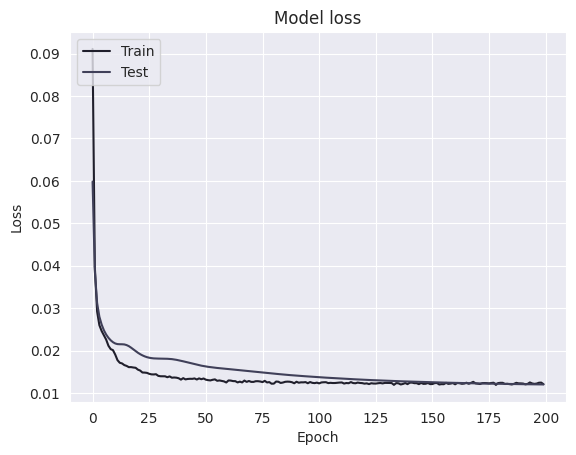

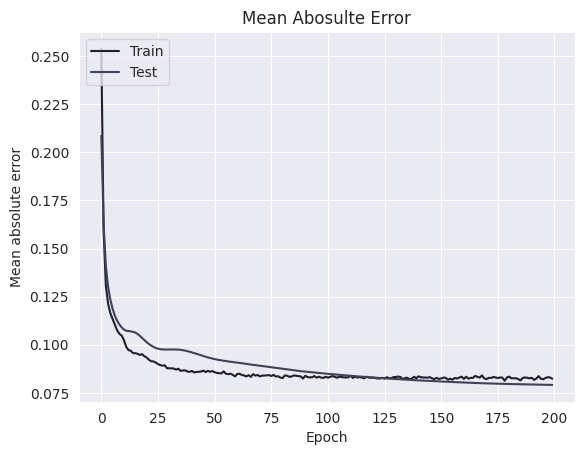

In [37]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation mae values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Abosulte Error')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## alignment

In [ ]:
X_test = pd.read_csv('test_V2.csv')
X_test = X_test.groupby(['matchId','groupId','matchType']).first().reset_index()
X_test = X_test[['matchId','groupId','matchType','numGroups','maxPlace','kills','killPlace']]

group = X_test_grp.groupby(['matchId'])
X_test_grp['winPlacePerc'] = predictions
X_test_grp['_rank.winPlacePerc'] = group['winPlacePerc'].rank(method='min')
X_test = pd.merge(X_test, X_test_grp)

In [ ]:
fullgroup = (X_test['numGroups'] == X_test['maxPlace'])

# full group (201366) --> calculate from rank
subset = X_test.loc[fullgroup]
X_test.loc[fullgroup, 'winPlacePerc'] = (subset['_rank.winPlacePerc'].values - 1) / (subset['maxPlace'].values - 1)

# not full group (684872) --> align with maxPlace
subset = X_test.loc[~fullgroup]
gap = 1.0 / (subset['maxPlace'].values - 1)
new_perc = np.around(subset['winPlacePerc'].values / gap) * gap  # half&up
X_test.loc[~fullgroup, 'winPlacePerc'] = new_perc

X_test['winPlacePerc'] = X_test['winPlacePerc'].clip(lower=0,upper=1)

In [ ]:
from tqdm import tqdm

# credit to https://www.kaggle.com/nagroda100/pubg-submission-postprocessor/code
print("Checking for anomalies in the winPlacePerc - players with same number of kills should have scores in order of killPlace")

do_correct = True
iteration_number = 1

while do_correct & (iteration_number <= 1000):
    X_test.sort_values(ascending=False, by=["matchId","kills","killPlace","winPlacePerc","groupId"], inplace=True)
    X_test["winPlacePerc_diff"] = X_test["winPlacePerc"].diff()
    X_test["kills_diff"] = X_test["kills"].diff()
    X_test["prev_matchId"] = X_test["matchId"].shift(1)
    X_test["prev_groupId"] = X_test["groupId"].shift(1)
    X_test["prev_winPlacePerc"] = X_test["winPlacePerc"].shift(1)

    df_sub2 = X_test[(X_test["winPlacePerc_diff"] < 0)
                     & (X_test["kills_diff"] == 0)
                     & (X_test["matchId"] == X_test["prev_matchId"])]
    anomalies_count = len(df_sub2)

    print("Iteration " + str(iteration_number) + " Anomalies count: " + str(anomalies_count))

    changed_groups = list()

    if anomalies_count > 0:
        print()
        print("Looking for pairs to change...")

        df_sub2["new_winPlacePerc"] = df_sub2["winPlacePerc"]

        df_sub3 = pd.DataFrame()

        for i in tqdm(range(1, min(15001, max(anomalies_count, 2))),
                      desc="Identifying unique groups", mininterval=10):
            row = df_sub2.iloc[i - 1]
            id_prev = str(row["prev_matchId"]) + "!" + str(row["prev_groupId"])
            id_cur = str(row["matchId"]) + "!" + str(row["groupId"])
            if (not id_prev in changed_groups) & (not id_cur in changed_groups):
                changed_groups.append(id_prev)
                changed_groups.append(id_cur)
                df_sub3 = df_sub3.append({"matchId": row["matchId"], "groupId": row["prev_groupId"],
                                          "new_winPlacePerc": row["winPlacePerc"]},
                                         sort=False, ignore_index=True)
                df_sub3 = df_sub3.append({"matchId": row["matchId"], "groupId": row["groupId"],
                                          "new_winPlacePerc": row["prev_winPlacePerc"]},
                                         sort=False, ignore_index=True)

        df_sub3.drop_duplicates(inplace=True)
        X_test = X_test.merge(df_sub3, on=["matchId", "groupId"], how="left")
        notna = X_test["new_winPlacePerc"].notna()
        X_test.loc[notna, "winPlacePerc"] = X_test.loc[notna]["new_winPlacePerc"]
        X_test.drop(labels="new_winPlacePerc", axis=1, inplace=True)
        del df_sub2
        del df_sub3
        df_sub2 = None
        df_sub3 = None
        gc.collect()
    else:
        do_correct = False

    iteration_number = iteration_number + 1

if do_correct:
    print("Limit of iterations reached...")

print("Finished correcting winPlacePerc")

/Users/vipulgaur/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Identifying unique groups:   0%|          | 0/105 [00:00<?, ?it/s]

Checking for anomalies in the winPlacePerc - players with same number of kills should have scores in order of killPlace
Iteration 1 Anomalies count: 106

Looking for pairs to change...


Identifying unique groups:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration 2 Anomalies count: 5

Looking for pairs to change...
Iteration 3 Anomalies count: 1

Looking for pairs to change...


Identifying unique groups: 100%|██████████| 1/1 [00:00<00:00, 182.02it/s]


Iteration 4 Anomalies count: 0
Finished correcting winPlacePerc


In [ ]:
# edge cases
X_test.loc[X_test['maxPlace'] == 0, 'winPlacePerc'] = 0
X_test.loc[X_test['maxPlace'] == 1, 'winPlacePerc'] = 1  # nothing
X_test.loc[(X_test['maxPlace'] > 1) & (X_test['numGroups'] == 1), 'winPlacePerc'] = 0
X_test['winPlacePerc'].describe()

count   7,489.000
mean        0.386
std         0.430
min         0.000
25%         0.000
50%         0.085
75%         0.897
max         1.000
Name: winPlacePerc, dtype: float64